

$\color{red}{\text{WARNING:}}$ remember to set GPU in the Notebook settings:


```
Runtime > Change runtime type > GPU
```




# Import's and Hyperparameters

In [ ]:
# Let's start by importing the required libraries 
# In Google Colab, importing from keras or from tensorflow.keras is equivalent for tf.version > 2 BUT tensorflow.keras should be used
# see https://pyimagesearch.com/2019/10/21/keras-vs-tf-keras-whats-the-difference-in-tensorflow-2-0/

import os
import cv2
import copy
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.math import reduce_sum
from tensorflow.keras.layers import *
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
tf.__version__

'2.12.0'

In [ ]:
# Path to my dataset: EDIT IT WITH YOUR OWN PATH to the folder
path = "/content/gdrive/MyDrive/corsoDL_UniVPM/2_Segmentazione/1_polmone"
train_path = os.path.join(path, "training")
valid_path = os.path.join(path, "validation")

In [ ]:
# Hyperparameters that will be used for training: batch size, lr, number of epochs...
BATCH_SIZE = 8
LR = 0.0001
MOMENTUM = 0.98
EPOCHS = 20
INPUT_SIZE = (272, 192)
INP_CHANNELS = 1
OUT_MASKS = 1

# Import the data

Each of the folders *training* and *validation* contains two sub-folders: 

*   *images*, that contains the X-Ray images to segment;
*   *masks*, that contains the silhouttes of the lungs, manually segmented (annotated) from the images. 

We need to load all the images and the respective masks off-line (i.e., not during the training), otherwise it would take too long to train the network.

In [ ]:
def preprocess(img, mask):
  img = cv2.resize(img, (INPUT_SIZE[1], INPUT_SIZE[0]))
  img = (img - np.mean(img))/np.std(img)
  
  mask = cv2.resize(mask, (INPUT_SIZE[1], INPUT_SIZE[0]))
  mask = mask / 255

  return img, mask

In [ ]:
def get_dataset(path):
  imgs = os.listdir(os.path.join(path, 'images'))

  X = np.empty((len(imgs), *INPUT_SIZE, INP_CHANNELS))
  y = np.empty((len(imgs), *INPUT_SIZE, INP_CHANNELS)) 

  for idx, img in enumerate(imgs):
    image = cv2.imread(os.path.join(path, 'images', img))[:, :, 0]
    if idx == 0:
      print("orginal image size:", image.shape)
    print(f"\rloading: {idx/len(imgs):.3f}%", end="")
    image = cv2.resize(image, (INPUT_SIZE[1], INPUT_SIZE[0]))
    mask = cv2.imread(os.path.join(path, 'masks', img))[:, :, 0]
    # Normalize each image: (img-mean)/stand_dev
    image, mask = preprocess(image, mask)
    X[idx, :, :, 0] = image
    y[idx, :, :, 0] = mask

  print()
  
  return X, y

In [ ]:
X_train, y_train = get_dataset(train_path)
X_valid, y_valid = get_dataset(valid_path)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

orginal image size: (4892, 4020)
loading: 0.991%
orginal image size: (4892, 4020)
loading: 0.964%
(107, 272, 192, 1) (107, 272, 192, 1)
(28, 272, 192, 1) (28, 272, 192, 1)


## Inspect the data

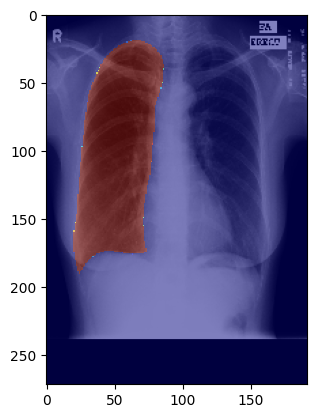

In [ ]:
# Get sample images
plt.figure(1)
plt.imshow(X_train[15], cmap='gray')
plt.imshow(y_train[15], 'jet', interpolation='none', alpha=0.5)

# Data augmentation

We will rotate and shift the images from their original positions. We could use more, but some augmentation functions would be useless: e.g., since the task is to segment the right lung, it would be counterproductive to flip the image.

If we used non-geoometrical augmentation, e.g. pixel-wise augmentation like brightness or contrast shifts, there would be no need to apply the same functions to the masks, too.

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.rotate_inputs = RandomRotation(factor=0.1, seed=seed)
    self.rotate_labels = RandomRotation(factor=0.1, seed=seed)
    self.shift_inputs = RandomTranslation(height_factor=0.1, width_factor=0.1, seed=seed)
    self.shift_labels = RandomTranslation(height_factor=0.1, width_factor=0.1, seed=seed)

  
  def call(self, inputs, labels):
    inputs = self.rotate_inputs(inputs)
    inputs = self.shift_inputs(inputs)
    labels = self.rotate_labels(labels)
    labels = self.shift_labels(labels)
    return inputs, labels

# DataGenerator class
 

In this assignment we will use the DataGenerator class. It is a different way to handle tensors for training and validation.

 DataGenerator class generates itself batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).

The augmentation is performed according to the following scheme:

<figure>
  <img src = "https://drive.google.com/uc?id=18F5WVeO14diPDQ6Yu8bOPn4vi4cPgWZB") width="700px">
</figure>


In [ ]:
class DataGenerator(Sequence):
    def __init__(self, inputs, masks, batch_size, augment=None, shuffle=True):
        'The constructor can be expanded with as many attributes as needed'
        self.inputs = inputs
        self.masks = masks
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment_class = augment
        self.img_size = INPUT_SIZE
        self.inp_chan = INP_CHANNELS
        self.out_chan = OUT_MASKS

        self.on_epoch_end()

    def __len__(self):
        'Take all batches in each iteration'
        return int(np.floor(len(self.inputs) / self.batch_size))

    def __getitem__(self, index):
        'Get next batch'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.inputs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_idx):
        'Generates data containing batch_size samples'
        X = np.empty((self.batch_size, *self.img_size, self.inp_chan), dtype=np.float32)
        Y = np.empty((self.batch_size, *self.img_size, self.out_chan), dtype=np.float32)
        for i_batch, id in enumerate(list_idx):
          # Store samples and masks
          img = self.inputs[id]
          mask = self.masks[id]

          # Augment
          if self.augment_class is not None:
            augment = self.augment_class(seed=random.randint(0,100))
            img, mask = augment(img, mask)

          X[i_batch, :, :, :] = img
          Y[i_batch, :, :, :] = mask

        return X, Y

In [ ]:
train_generator = DataGenerator(
    inputs=X_train, masks=y_train, batch_size=BATCH_SIZE, augment=Augment)
valid_generator = DataGenerator(
    inputs=X_valid, masks=y_valid, batch_size=BATCH_SIZE)

# Semantic-segmentation model: U-Net

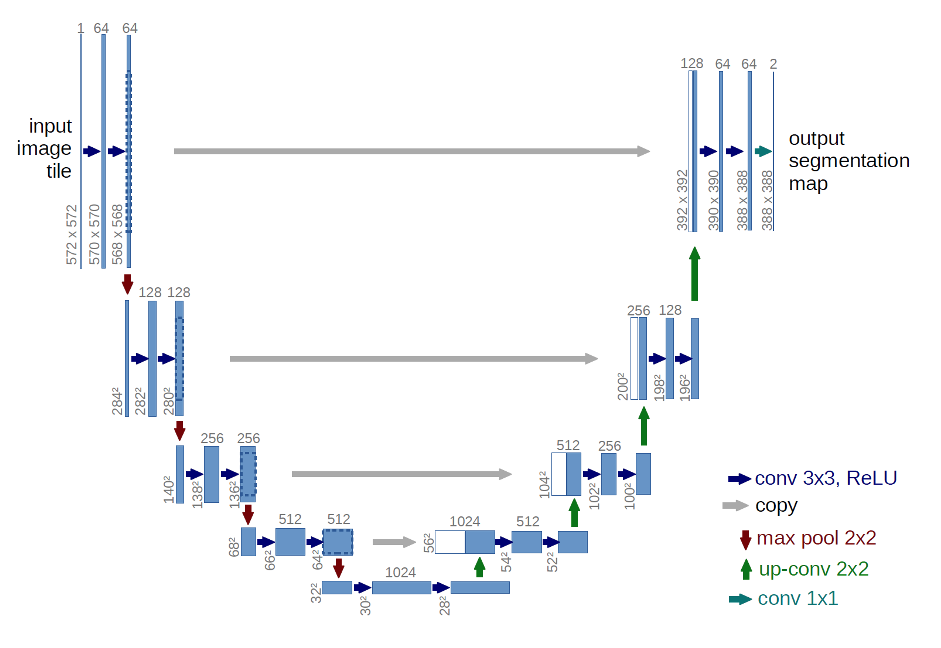








In [ ]:
def encoder_stage(input, stage):
  encod = Conv2D(64*(2**stage), 3, activation='relu', padding='same')(input)
  encod = Conv2D(64*(2**stage), 3, activation='relu', padding='same')(encod)
  pool = MaxPooling2D(pool_size=(2, 2))(encod)
  return pool, encod


def decoder_stage(input, stage, skip_connection):
  decod = UpSampling2D(size = (2,2))(input)
  decod = Conv2D(512/(2**stage), 2, activation='relu', padding='same')(decod)
  decod = concatenate([skip_connection, decod], axis=3)
  decod = Conv2D(512/(2**stage), 3, activation='relu', padding='same')(decod)
  return Conv2D(512/(2**stage), 3, activation='relu', padding='same')(decod)


def unet(input_size=(*INPUT_SIZE, 1)):
    inputs = Input(input_size)
    
    # encoder
    pooled1, conv1 = encoder_stage(inputs, 0)
    pooled2, conv2 = encoder_stage(pooled1, 1)
    pooled3, conv3 = encoder_stage(pooled2, 2)
    pooled4, conv4 = encoder_stage(pooled3, 3)
    
    # bottleneck
    bn = Conv2D(1024, 3, activation='relu', padding='same')(pooled4)
    bn = Conv2D(1024, 3, activation='relu', padding='same')(bn)

    # Decoder
    upconv1 = decoder_stage(bn, 0, conv4)
    upconv2 = decoder_stage(upconv1, 1, conv3)
    upconv3 = decoder_stage(upconv2, 2, conv2)
    upconv4 = decoder_stage(upconv3, 3, conv1)

    # Output
    out = Conv2D(16, 3, activation = 'relu', padding = 'same')(upconv4)
    # out = Conv2D(1, 1, activation = 'sigmoid')(out)
    out = Conv2D(1, 1, activation = 'sigmoid')(out)

    return Model(inputs, out)

# Train the model from scratch

The cross-entropy loss function is not ideal for segmentation tasks due to heavy **class imbalance** (there are typically not many positive regions). 

A much more common loss for segmentation tasks is based on the **Dice similarity coefficient**, which is a measure of how well two contours overlap and ranges from 0 (complete mismatch) to 1 (perfect match).

In general, for two sets $A$ and $B$, the Dice similarity coefficient is defined as: 
$$\text{DSC}(A, B) = \frac{2 \times |A \cap B|}{|A| + |B|} = \frac{2 \times TP}{2 \times TP + FP + FN}$$

<figure>
<img src="https://www.researchgate.net/publication/328671987/figure/fig4/AS:688210103529478@1541093483784/Calculation-of-the-Dice-similarity-coefficient-The-deformed-contour-of-the-liver-from.ppm" width="30%">
</figure>

$$\text{IoU}(A, B) = \frac{|A \cap B|}{|A \cup B|} = \frac{TP}{TP+FP+FN}$$


In [ ]:
class DiceLoss(tf.keras.losses.Loss):
  def __init__(self):
    super().__init__()
    self.redsum = tf.math.reduce_sum

  def call(self, y_true, y_pred, smooth=0.01):
    intersec = self.redsum(y_true * y_pred)
    dice = (2 * intersec + smooth) / (self.redsum(y_true) + self.redsum(y_pred) + smooth)

    return 1 - dice 

In [ ]:
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])

In [ ]:
model = unet()
model.compile(optimizer=Adam(learning_rate=LR), loss=DiceLoss(), metrics=iou)

save_filename = "u_net_softmax"

In [ ]:
train_path = os.path.join(path, "trainings")
if not os.path.exists(train_path):
  os.mkdir(train_path)

callbacks_list = ModelCheckpoint(os.path.join(train_path, f"{save_filename}.hdf5"),
                                 monitor='val_loss', verbose=1, save_best_only=True)
csv_logger = CSVLogger(os.path.join(train_path, f"{save_filename}.csv"), 
                       append=True, separator=';')

history = model.fit(train_generator, validation_data=valid_generator, 
                    epochs=EPOCHS, verbose=1, callbacks=[callbacks_list, csv_logger])

Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 0.7594 - io_u: 0.0000e+00
Epoch 1: val_loss improved from inf to 0.76155, saving model to /content/gdrive/MyDrive/corsoDL_UniVPM/2_Segmentazione/1_polmone/trainings/u_net_softmax.hdf5
13/13 [==============================] - 42s 998ms/step - loss: 0.7594 - io_u: 0.0000e+00 - val_loss: 0.7615 - val_io_u: 0.0000e+00
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 0.7566 - io_u: 0.0000e+00
Epoch 2: val_loss did not improve from 0.76155
13/13 [==============================] - 13s 989ms/step - loss: 0.7566 - io_u: 0.0000e+00 - val_loss: 0.7630 - val_io_u: 0.0000e+00
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 0.7602 - io_u: 0.0000e+00
Epoch 3: val_loss improved from 0.76155 to 0.76064, saving model to /content/gdrive/MyDrive/corsoDL_UniVPM/2_Segmentazione/1_polmone/trainings/u_net_softmax.hdf5
13/13 [==============================] - 16s 1s/step - loss: 0.7602 - io_u: 0.0000e+00 

## Training curves

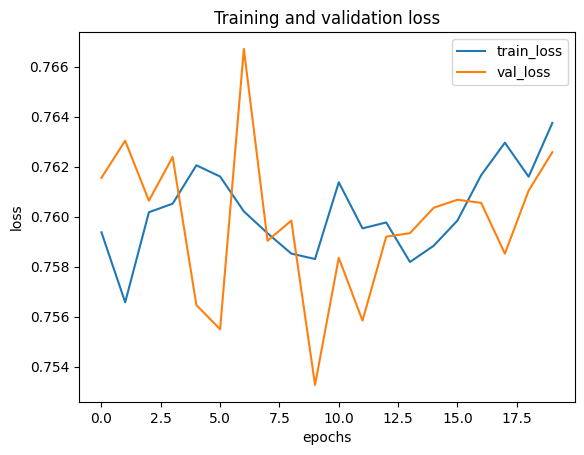

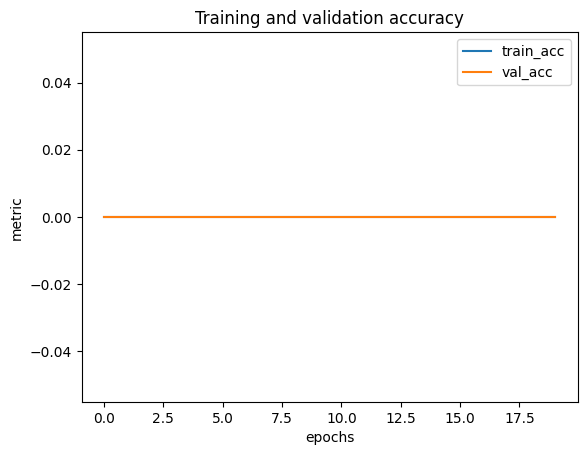

In [ ]:
plt.figure()
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.legend()

plt.figure()
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('metric')
plt.plot(np.arange(0, EPOCHS), history.history["io_u"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history["val_io_u"], label="val_acc")
plt.legend()

# Test the model

In [ ]:
# If necessary, load a set of previously-trained weights
# model.load_weights(os.path.join(path, "trainings", "u_net.hdf5")

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

test_image = cv2.imread(os.path.join(path, "MCUCXR_0254_imm.png"))[:, :, 0]
test_mask = cv2.imread(os.path.join(path, "MCUCXR_0254.png"))[:, :, 0]

test_image, test_mask = preprocess(test_image, test_mask)

test_image = img_to_array(test_image)
test_image = test_image.reshape((1, test_image.shape[0], test_image.shape[1], test_image.shape[2]))
prediction = model.predict(test_image)
pred = copy.copy(prediction)
pred [prediction > 0.5] = 1
pred [pred < 0.5] = 0

1/1 [==============================] - 1s 1s/step


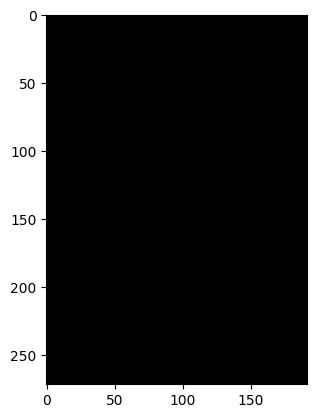

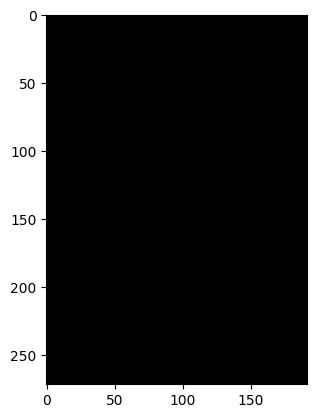

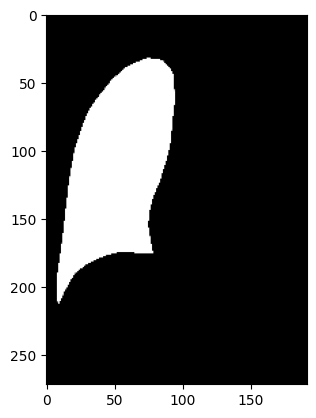

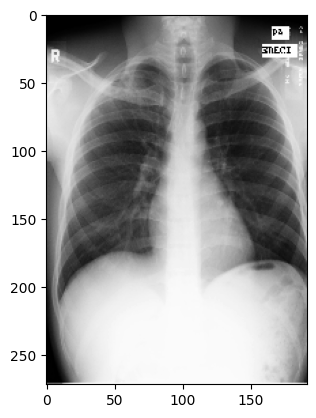

In [ ]:
plt.figure()
plt.imshow(prediction[0,:,:,0], cmap='gray')
plt.figure()
plt.imshow(pred[0,:,:,0], cmap='gray')
plt.figure()
plt.imshow(test_mask, cmap='gray')
plt.figure()
plt.imshow(test_image[0,:,:,0], cmap='gray')

In [ ]:
from sklearn.metrics import accuracy_score
test_mask = test_mask/255
a = test_mask.flatten()
b = pred[0,:,:,0].flatten()
a = a.astype(int)
b = b.astype(int)

accuracy = accuracy_score(a, b)
print("testing accuracy:", accuracy)

testing accuracy: 0.8088426776960784


In [ ]:
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])(a,b)
print("iou:", iou)

iou: tf.Tensor(0.80884266, shape=(), dtype=float32)


In [ ]:
dice = DiceLoss()
dice(test_mask, pred[0,:,:,0])

InvalidArgumentError: ignored

Eg: 20 elements, among which only 15 are well predicted by the model (8TP + 7TN + 2FP + 3FN).

$$accuracy = \frac{TP + TN}{TP + TN + FN + TP} = \frac{8 + 7}{20} = 0.75$$

$$precision = \frac{TP}{TP + FP} = \frac{8}{8 + 2} = 0.8$$

$$recall = \frac{TP}{TP + FN} = \frac{8}{8 + 3} = 0.72 $$

$$F1 score = \frac{2 \times precision \times recall}{precision + recall} = \frac{2 \times 0.8 \times 0.72}{0.8 + 0.72} = 0.75 $$

$$DSC = \frac{2 \times TP}{2 \times TP + FN + FP} = \frac{2 \times 8}{2 \times 8 + 2 + 3} = 0.76$$

$$IoU = \frac{|A \cap B|}{|A \cup B|} = \frac{8}{8 + 2 + 3} = 0.61 $$

DSC : average = IoU : worst case.

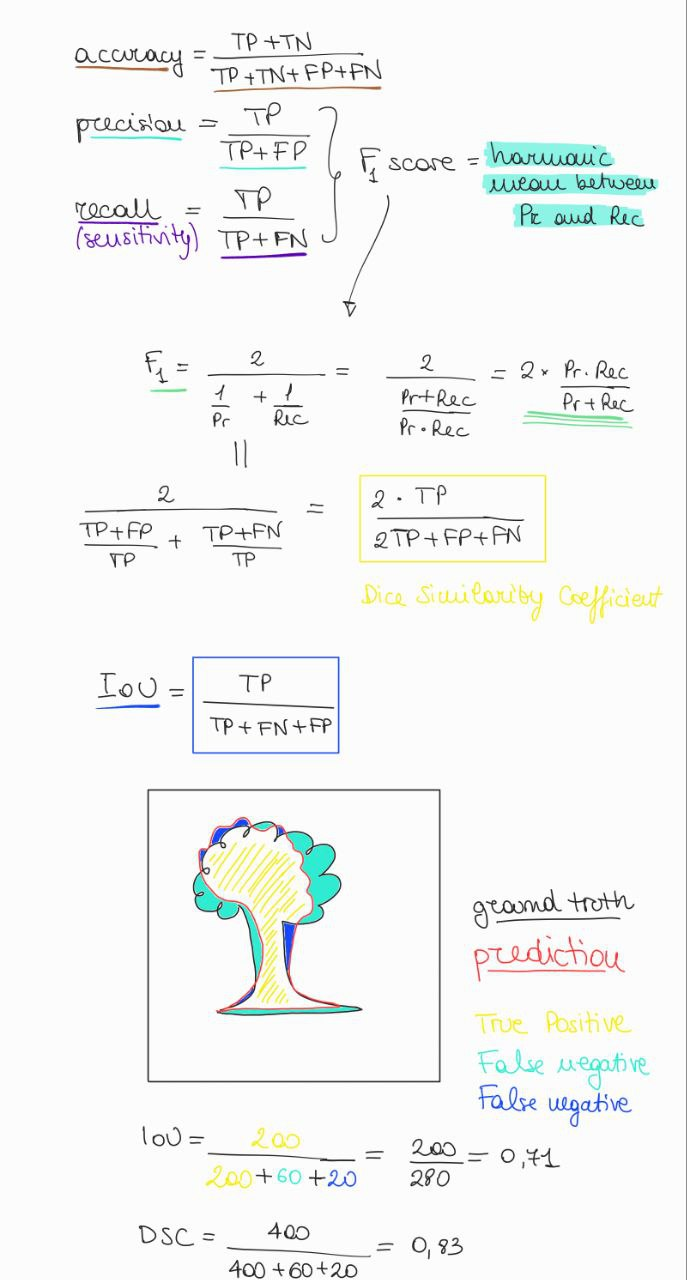